# Credit Card Fraud Detection
## Objective
The objective of this project is to develop a robust machine learning model capable of accurately detecting fraudulent credit card transactions in real-time. This system aims to enhance fraud detection capabilities, minimize financial losses for cardholders and financial institutions, and maintain a low false positive rate, thereby contributing to proactive measures for securing credit card transactions and safeguarding financial interests in the digital economy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ArchanaAnalytics/DS-Portfolio/refs/heads/main/Datasets/credit_card_transactions.csv')
df.head()

,Transaction_ID,Card_Type,Merchant_Category,Transaction_Amount,Transaction_DateTime,City,Country,Cardholder_Age,Cardholder_Gender,Cardholder_Monthly_Income,Cardholder_Average_Spend,Credit_Limit,Device_Type,Day_of_Week,Is_Fraudulent
0,W963UK57,Mastercard,Utility bill,2721.4,01-01-2020 09:43,Tokyo,Japan,23.0,Female,9463.0,3636.965,10000.0,Unknown,Wednesday,No
1,V606KV56,UnionPay,Retail,8395.6,03-01-2020 16:26,Tokyo,Japan,49.0,Male,14812.0,8917.912,15000.0,Desktop,Friday,No
2,R531NU70,Visa,Transportation,19328.0,04-01-2020 03:40,London,UK,NaN,Male,21092.0,10666.860,20000.0,Desktop,Saturday,No
3,T783GF79,American Express,Online Shopping,16738.1,04-01-2020 14:56,Tokyo,Japan,52.0,Female,14807.0,17315.552,20000.0,Desktop,Saturday,Yes
4,K256ZN73,American Express,Retail,8117.0,04-01-2020 17:26,Chicago,USA,37.0,Female,17447.0,5271.309,20000.0,Mobile,Saturday,No


In [3]:
df.shape

(5000, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Transaction_ID             5000 non-null   object 
 1   Card_Type                  4983 non-null   object 
 2   Merchant_Category          4978 non-null   object 
 3   Transaction_Amount         4994 non-null   float64
 4   Transaction_DateTime       5000 non-null   object 
 5   City                       5000 non-null   object 
 6   Country                    5000 non-null   object 
 7   Cardholder_Age             4865 non-null   float64
 8   Cardholder_Gender          4911 non-null   object 
 9   Cardholder_Monthly_Income  4686 non-null   float64
 10  Cardholder_Average_Spend   4792 non-null   float64
 11  Credit_Limit               4991 non-null   float64
 12  Device_Type                4960 non-null   object 
 13  Day_of_Week                5000 non-null   objec

### 1. Exploratory Data Analysis (EDA)

### Univariate Analysis:

In [5]:
df['Transaction_ID'].nunique()

5000

There are 5000 unique transaction IDs in the dataset, indicating that each transaction is represented by a distinct ID.

In [6]:
df['Is_Fraudulent'].value_counts(normalize=True).map("{:.2%}".format)

,proportion
Is_Fraudulent,
No,73.36%
Yes,26.64%


The dataset appears to be imbalanced, with 73.36% of the transactions labeled as not fraudulent ('No') and 26.64% labeled as fraudulent ('Yes').

In [7]:
df['Credit_Limit'].unique()

array([10000., 15000., 20000.,  5000.,    nan])

In [8]:
categorical_cols = df.drop(columns=['Transaction_ID', 'Transaction_DateTime']).select_dtypes(include='O').columns.to_list()
categorical_cols.append('Credit_Limit')
print(categorical_cols)

['Card_Type', 'Merchant_Category', 'City', 'Country', 'Cardholder_Gender', 'Device_Type', 'Day_of_Week', 'Is_Fraudulent', 'Credit_Limit']


#### Distribution of Categorical Features

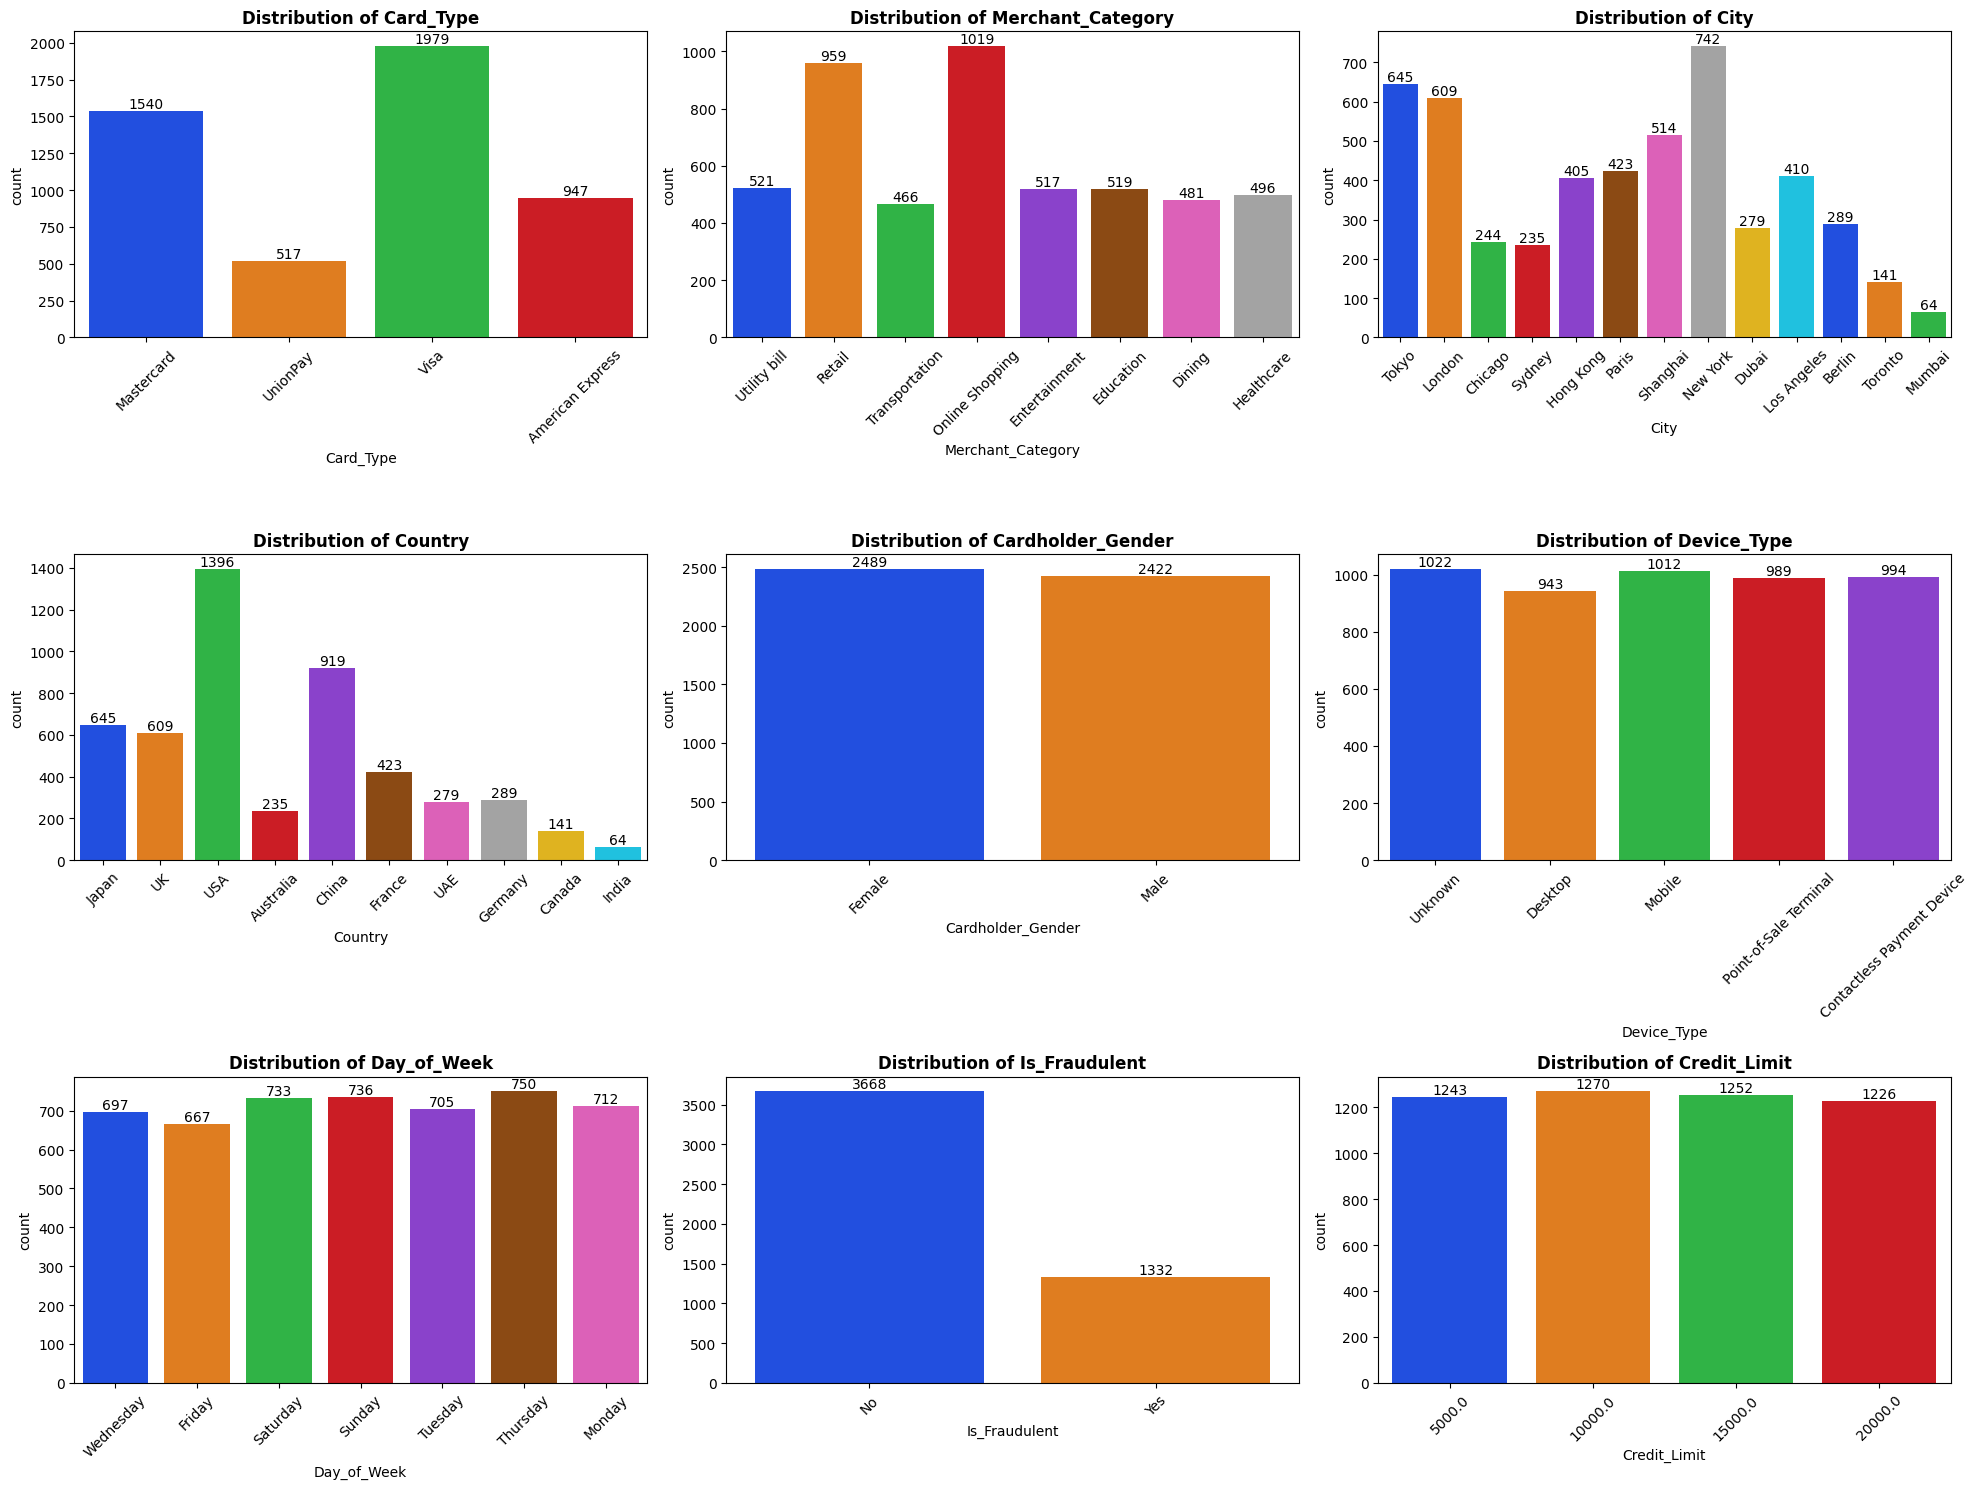

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,15))
for col, subplot in zip(categorical_cols, axes.flatten()):
    #sns.countplot(x=df[col], ax=subplot).bar_label(subplot.containers[0]).bar_label(subplot.containers[0])
    sns.countplot(x=col, data=df, ax=subplot, palette='bright').set_title(f'Distribution of {col}', fontweight='bold')
    for container in subplot.containers: subplot.bar_label(container)
    subplot.set_xticklabels(subplot.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

- From the above countplots,
  
    - People who are doing `online shopping` are highly utilizing the credit card and this may be the spot which is vulnerable for fraudulent activities.
      
    - `Visa Card` is the most prevalent card type in our dataset due to it's unique features and benefits.
      
    - State wise transactions count are almost same but in big picture `South` stand out from the crowd.

    - There is no significant difference in the `Gender` count.

    - Most of the transactions are done by an `Unknown` devices. This opens the door for fraudulent activities.

    - Transaction count is almost evenly distributed across `week days`.

    - The distribution of `Is_Fradulant` shows our dataset is imbalance and considering only the `accuracy scores` of a model won't be the right choice.

#### Distribution of Numerical Features

In [10]:
numerical_cols = df.select_dtypes(exclude='O').columns.to_list()
numerical_cols.remove('Credit_Limit')
print(numerical_cols)

['Transaction_Amount', 'Cardholder_Age', 'Cardholder_Monthly_Income', 'Cardholder_Average_Spend']


In [11]:
df[numerical_cols].describe().round(2)

,Transaction_Amount,Cardholder_Age,Cardholder_Monthly_Income,Cardholder_Average_Spend
count,4994.00,4865.00,4686.00,4792.00
mean,7466.80,49.11,13735.44,6305.83
std,4308.90,18.40,6947.16,4005.70
min,2500.80,18.00,3501.00,1028.24
25%,3974.25,33.00,7348.50,3333.67
50%,6092.20,49.00,13183.50,4954.79
75%,9837.35,65.00,18905.25,8373.24
max,19992.30,80.00,29991.00,19989.83


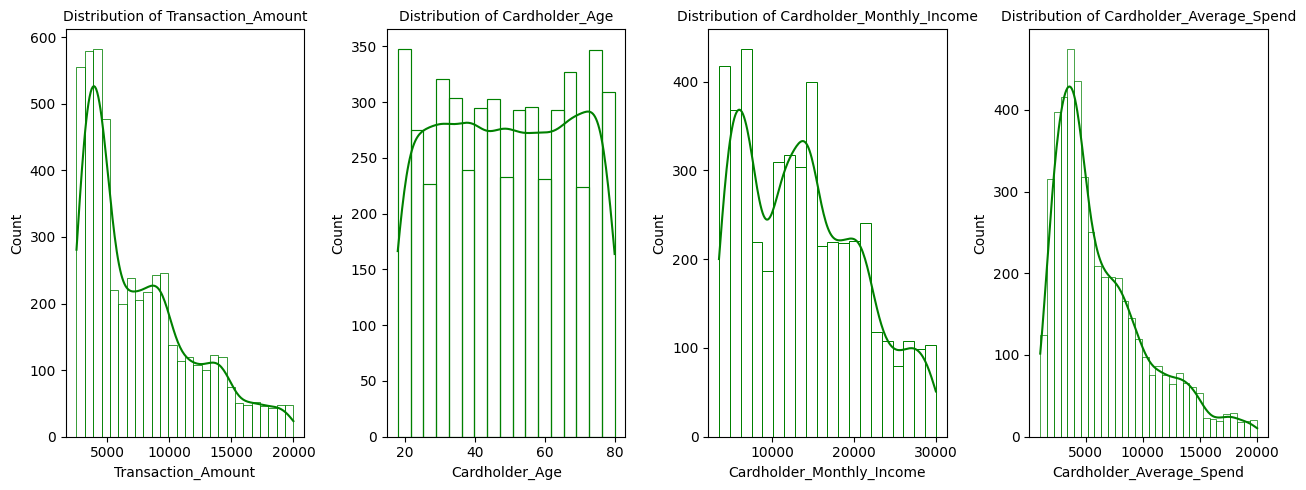

In [12]:
fig, axes = plt.subplots(ncols=4, figsize=(13,5))
for index, col in enumerate(numerical_cols):
    sns.histplot(data= df, x=col, kde=True, color='green', ax=axes[index], fill=False).set_title('Distribution of '+col, fontsize=10)
plt.tight_layout()
plt.show()

In [13]:
print(f'Skewness Scores : \n{df[numerical_cols].skew().to_string()}')

Skewness Scores : 
Transaction_Amount           0.968481
Cardholder_Age              -0.009025
Cardholder_Monthly_Income    0.428366
Cardholder_Average_Spend     1.155050


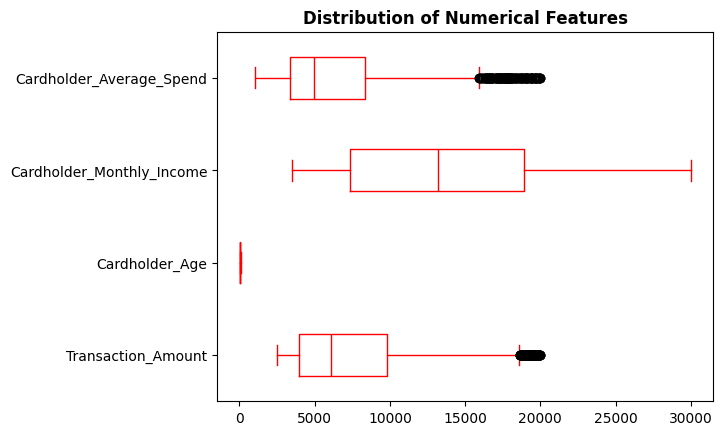

In [14]:
df[numerical_cols].plot(kind='box', vert=False, color='red')
plt.title('Distribution of Numerical Features', fontweight='bold')
plt.show()

- The `Descriptive statistics` and `Skewness Scores` clealy gives a picture that `Transaction_Amount` and `Cardholder_Average_Spend` are right skewed (contains outliers) and doesn't follow normal distribution.
  
    - `mean()` and `median()` have significant differences.
      
    - There is a huge spread between `75th Percentile` and the `max()` value.

### Bivariate Analysis

#### Distribution of Categorical Features by Is_Fraudulent

In [15]:
from scipy.stats import chi2_contingency

for col in categorical_cols:
    if col == 'Is_Fraudulent':
        continue
    else:
        chi_stats, p_value, dof, expected = chi2_contingency(pd.crosstab(df[col], df['Is_Fraudulent']))
        print(p_value, end='\n')
        print(f'{col} dependent on Is_Fraudulent\n' if p_value < 0.05 else f'{col} not dependent on Is_Fraudulent\n')

0.8886546574067218
Card_Type not dependent on Is_Fraudulent

0.8096213326541601
Merchant_Category not dependent on Is_Fraudulent

0.8190471163823679
City not dependent on Is_Fraudulent

0.8875522679493336
Country not dependent on Is_Fraudulent

0.1871287139472636
Cardholder_Gender not dependent on Is_Fraudulent

0.7407301570625034
Device_Type not dependent on Is_Fraudulent

0.40562701491890313
Day_of_Week not dependent on Is_Fraudulent

0.7298944805035263
Credit_Limit not dependent on Is_Fraudulent



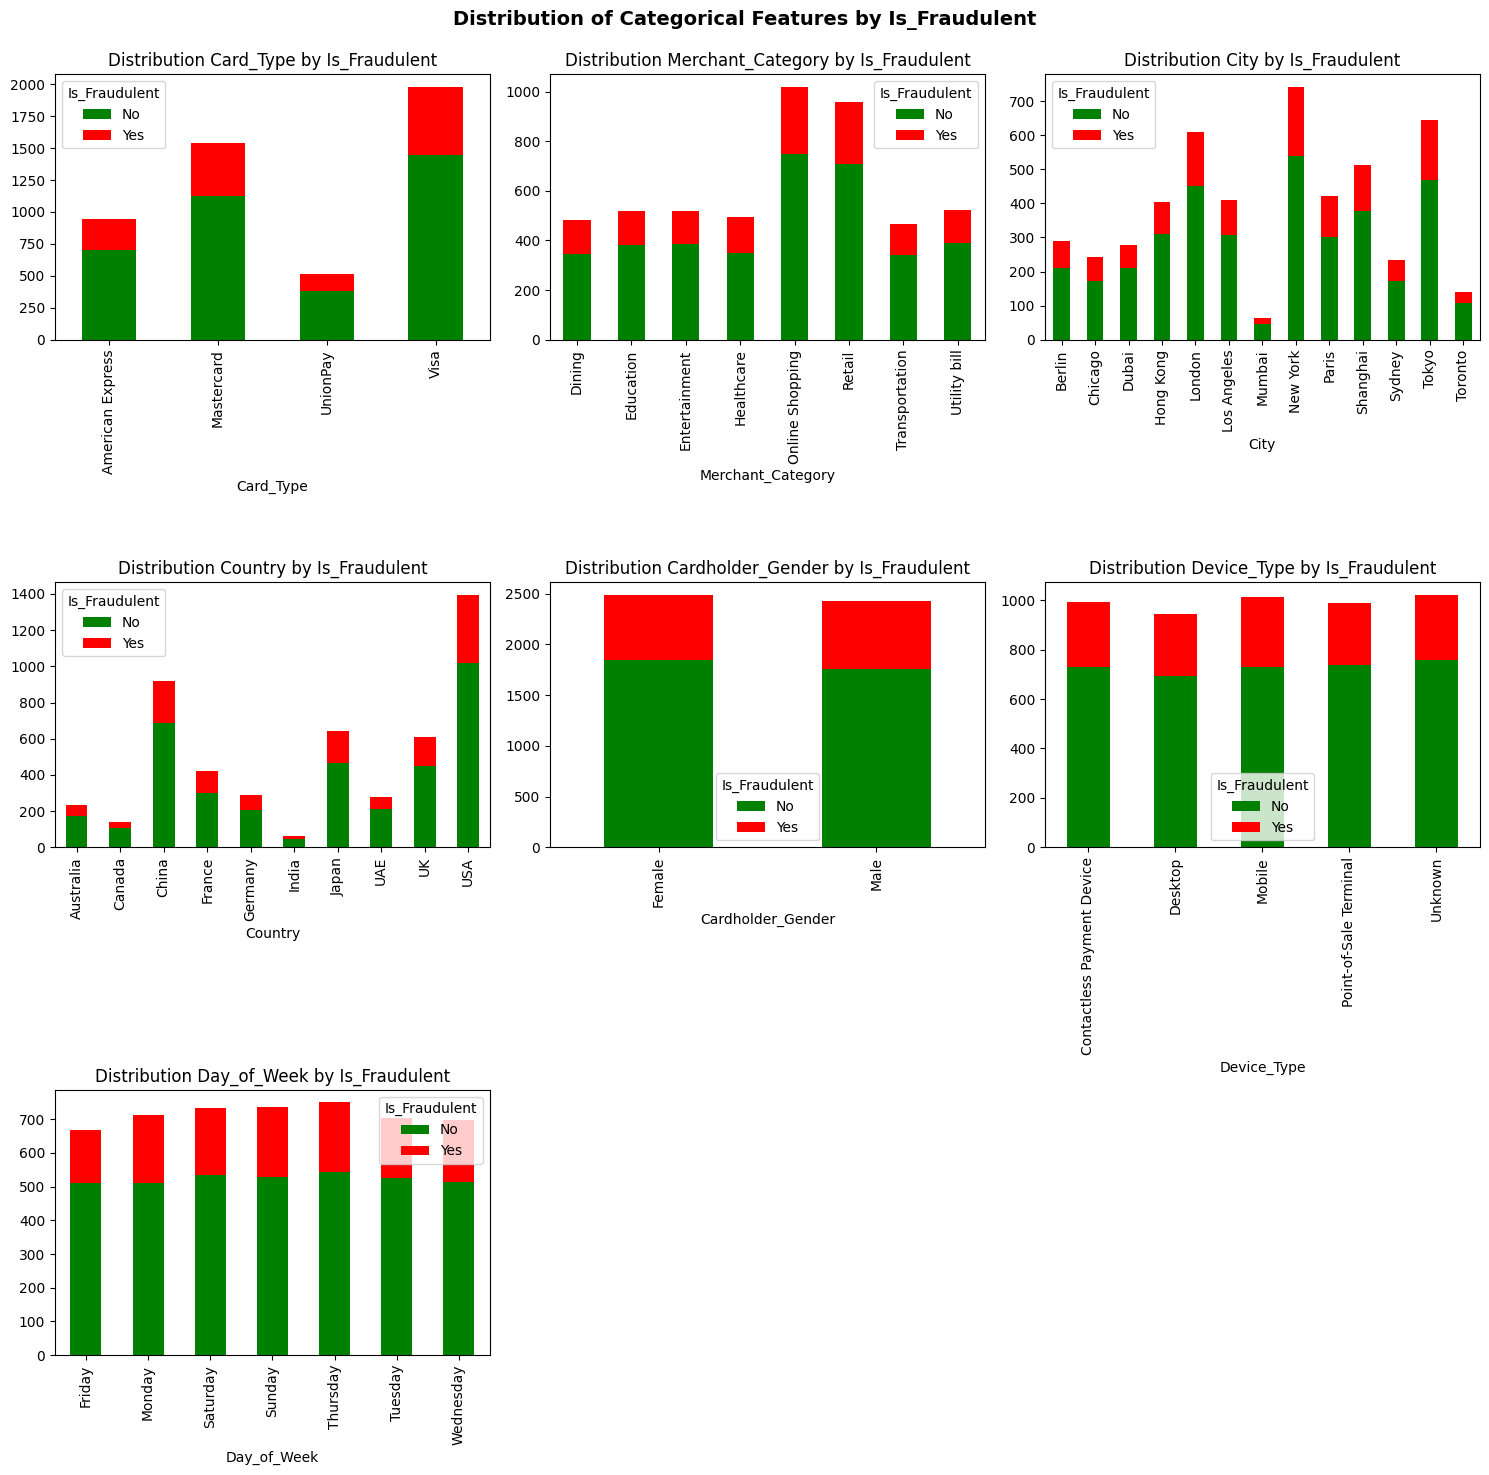

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for col, axis in zip(categorical_cols, axes):
    pd.crosstab(df[col], df['Is_Fraudulent']).plot(kind='bar', stacked=True, ax=axis, color=['green', 'red'])
    axis.set_title(f'Distribution {col} by Is_Fraudulent')

for i in range(1, 3):
    axes[-(i)].set_visible(False)

plt.suptitle('Distribution of Categorical Features by Is_Fraudulent\n', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

- From the above test and stacked bar chart it is clear that categorical features like `Card_Type`, `Merchant_Category`, `Location`, `Region`, `'Cardholder_Gende`',`'Device_Typ`',`'Day_of_Wee` are not dependent on target `'Is_Fraudulent`.'

- The statistical test proves that, there is a slight dependence `Region` with `Is_Fraudulent`.

#### Distribution of Transaction Amount by Is_Fraudulant

In [17]:
from scipy.stats import f_oneway

f_stats, p_value = f_oneway(df[df['Is_Fraudulent'] == 'Yes']['Transaction_Amount'],
                            df[df['Is_Fraudulent'] == 'No']['Transaction_Amount'])

if p_value < 0.05:
    print('There is a difference in the mean of Transaction_Amount for Is_Fraudulent')
else:
    print('There is no difference in the mean of Transaction_Amount for Is_Fraudulent')

There is no difference in the mean of Transaction_Amount for Is_Fraudulent


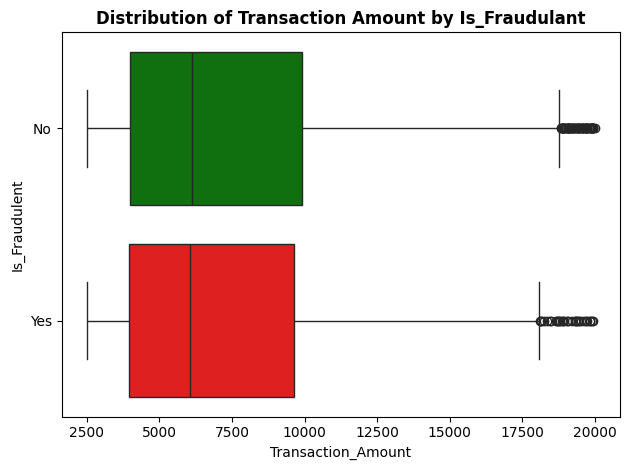

In [18]:
sns.boxplot(data=df, x='Transaction_Amount', y='Is_Fraudulent', hue='Is_Fraudulent', palette=['green', 'red'])
plt.title('Distribution of Transaction Amount by Is_Fraudulant', fontweight='bold')
plt.tight_layout()
plt.show()

- The distribution shows that most fraudulent transaction amounts fall in the range of 40,000 to 1,00,000.

- The statistical test confirms that the mean of two groups shows no significant differences which shows fraud transaction is not dependent on transaction amount.

- Rarely, fraudulent activities involve high transaction amounts, which can be considered outliers.

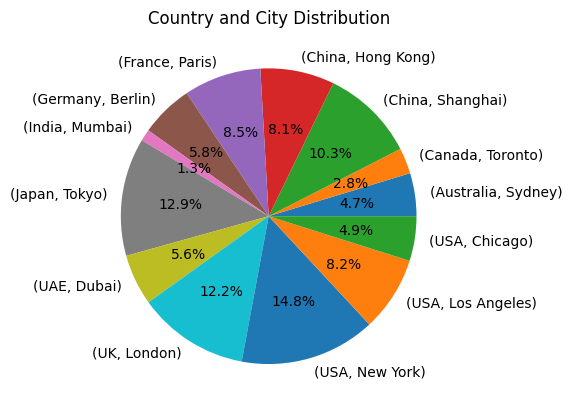

In [19]:
df.groupby('Country').City.value_counts().plot.pie(autopct='%1.1f%%', ylabel='')
plt.title('Country and City Distribution')
plt.show()

The majority of transactions in the dataset come from New York, USA, which accounts for the highest percentage of transactions at 14.8%.

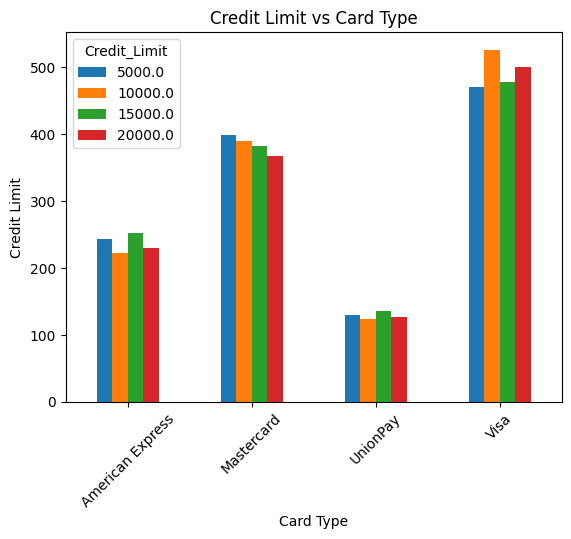

In [20]:
pd.crosstab(df['Card_Type'], df['Credit_Limit']).plot.bar()
plt.title('Credit Limit vs Card Type')
plt.xlabel('Card Type')
plt.ylabel('Credit Limit')
plt.xticks(rotation=45)
plt.show()

* **Visa** offers the highest credit limits across all categories.
* **American Express** generally has the lowest limits.

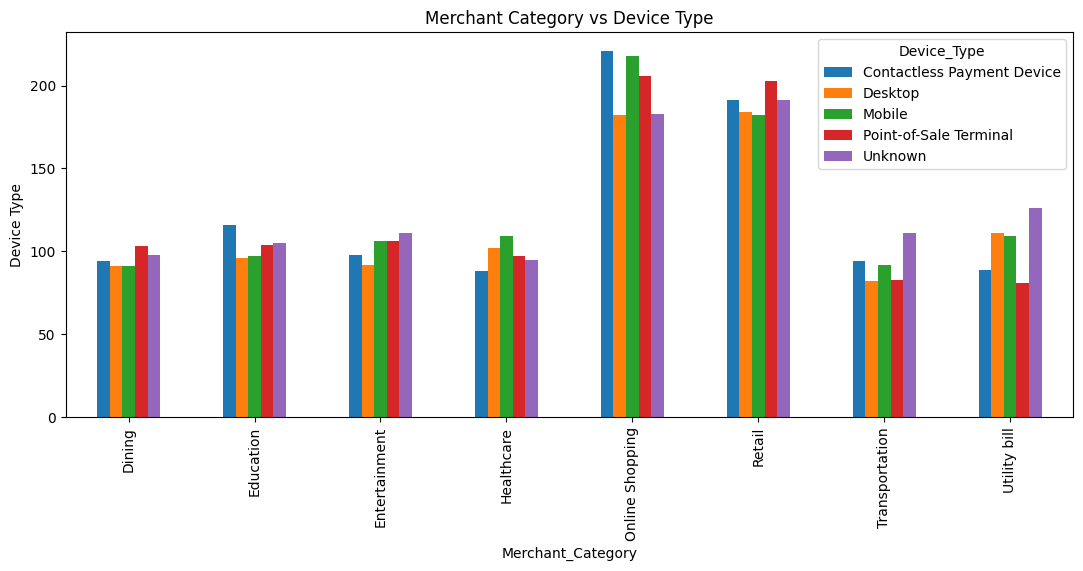

In [21]:
pd.crosstab(df['Merchant_Category'], df['Device_Type']).plot.bar(figsize=(13,5))
plt.title('Merchant Category vs Device Type')
plt.xlabel('Merchant_Category')
plt.ylabel('Device Type')
plt.show()

- **Mobile** and **Point-of-Sale Terminal** devices dominate across most merchant categories, with **Contactless Payment Devices** showing a slight preference for **Online Shopping**.

- **Desktop** usage is relatively low across all categories.

- Unknown device type is prevalent in Entertainment and Transportation.

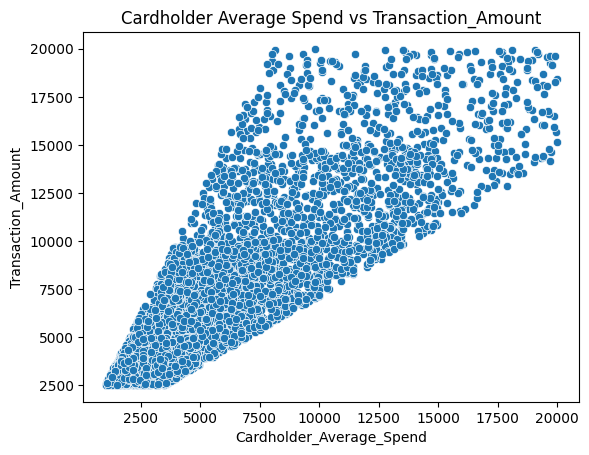

In [22]:
sns.scatterplot(x='Cardholder_Average_Spend', y='Transaction_Amount', data=df)
plt.title('Cardholder Average Spend vs Transaction_Amount')
plt.show()

- The plot suggests that cardholder spending is heavily influenced by their monthly income. Higher-income individuals tend to make larger transactions.

- This can help businesses target customers based on their income and spending habits. For example, businesses could focus their marketing efforts on cardholders with higher incomes, as they are more likely to make larger purchases.

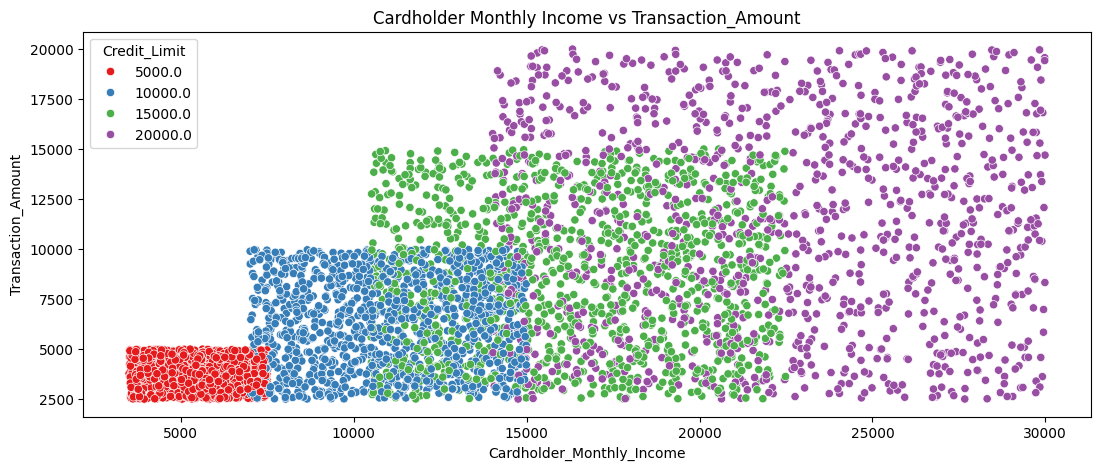

In [23]:
plt.figure(figsize=(13,5))
sns.scatterplot(x='Cardholder_Monthly_Income', y='Transaction_Amount', hue='Credit_Limit', data=df, palette='Set1')
plt.title('Cardholder Monthly Income vs Transaction_Amount')
plt.show()

- **Positive Correlation**: There appears to be a positive correlation between Cardholder Monthly Income and Transaction Amount. As the monthly income increases, the transaction amounts also tend to increase.

- **Clustering**: * The data points seem to cluster in certain areas of the plot. There are distinct clusters for different credit limit values, suggesting that cardholders with higher credit limits tend to make larger transactions.

- **Credit Limit Influence**: * The different colored dots representing different credit limits show that higher credit limits are associated with larger transaction amounts. This is expected as cardholders with higher limits have more spending power.


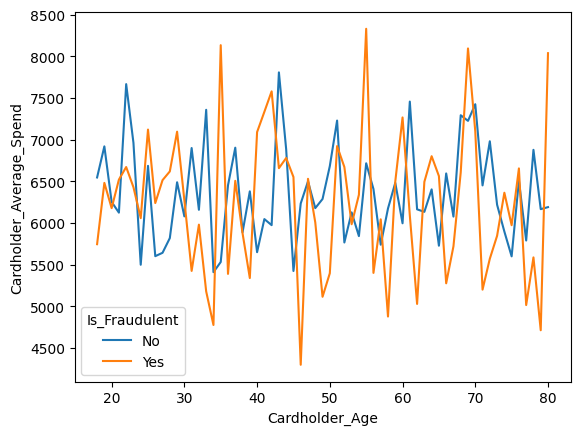

In [24]:
sns.lineplot(x=df['Cardholder_Age'], y=df['Cardholder_Average_Spend'], hue=df['Is_Fraudulent'], errorbar=None)
plt.show()

-  **Cardholder_Average_Spend** varies significantly across different **Cardholder_Age** groups, regardless of whether the transaction is fraudulent or not.

- There isn't a strong, consistent trend visible in the plot. The lines for both **Is_Fraudulent** categories fluctuate without a clear upward or downward direction.

### Time-Based Analysis

In [25]:
df.head()

,Transaction_ID,Card_Type,Merchant_Category,Transaction_Amount,Transaction_DateTime,City,Country,Cardholder_Age,Cardholder_Gender,Cardholder_Monthly_Income,Cardholder_Average_Spend,Credit_Limit,Device_Type,Day_of_Week,Is_Fraudulent
0,W963UK57,Mastercard,Utility bill,2721.4,01-01-2020 09:43,Tokyo,Japan,23.0,Female,9463.0,3636.965,10000.0,Unknown,Wednesday,No
1,V606KV56,UnionPay,Retail,8395.6,03-01-2020 16:26,Tokyo,Japan,49.0,Male,14812.0,8917.912,15000.0,Desktop,Friday,No
2,R531NU70,Visa,Transportation,19328.0,04-01-2020 03:40,London,UK,NaN,Male,21092.0,10666.860,20000.0,Desktop,Saturday,No
3,T783GF79,American Express,Online Shopping,16738.1,04-01-2020 14:56,Tokyo,Japan,52.0,Female,14807.0,17315.552,20000.0,Desktop,Saturday,Yes
4,K256ZN73,American Express,Retail,8117.0,04-01-2020 17:26,Chicago,USA,37.0,Female,17447.0,5271.309,20000.0,Mobile,Saturday,No


In [26]:
df.groupby('Day_of_Week')['Transaction_Amount'].describe()

,count,mean,std,min,25%,50%,75%,max
Day_of_Week,,,,,,,,
Friday,666.0,7647.499099,4249.151732,2502.3,4053.500,6707.05,10312.075,19560.6
Monday,712.0,7372.553933,4376.359122,2501.9,3895.600,5890.65,9708.900,19992.3
Saturday,732.0,7448.728005,4495.780031,2500.8,3799.825,5863.55,9923.100,19946.2
Sunday,734.0,7566.999455,4261.975679,2506.4,4167.850,6477.55,9825.225,19818.4
Thursday,749.0,7252.349266,4312.923438,2507.9,3872.900,5469.80,9556.000,19861.4
Tuesday,705.0,7532.935319,4260.820006,2508.3,4104.400,6368.70,9777.800,19899.8
Wednesday,696.0,7467.426580,4193.480385,2505.3,4015.075,6392.25,9802.925,19953.6


In [27]:
df['Transaction_DateTime'] = pd.to_datetime(df['Transaction_DateTime'], format="%d-%m-%Y %H:%M")
df['Year'] = df['Transaction_DateTime'].dt.year
df['Month'] = df['Transaction_DateTime'].dt.month
df['Hour'] = df['Transaction_DateTime'].dt.hour

#### Distribution of Time_of_Day by Is_Fraudulent

In [28]:
from scipy.stats import chi2_contingency

df['Time_of_Day'] = df['Transaction_DateTime'].dt.hour.apply(lambda x: 'Morning' if 6 <= x < 12 else
                                                             'Afternoon' if 12 <= x < 18 else
                                                             'Evening' if 18 <= x < 21 else
                                                             'Night' if 21 <= x < 24 else 'Midnight')

chi_stats, p_value, dof, expected = chi2_contingency(pd.crosstab(df['Time_of_Day'], df['Is_Fraudulent']))
print('P_value :', p_value)

P_value : 0.6376959369011247


Since the p-value is 0.6377, we fail to reject the null hypothesis. This means that there is no statistically significant association between the time of day a transaction occurs and whether it is fraudulent. Hence, based on this test, the time of day does not seem to be a good predictor of fraudulent transactions in this dataset.

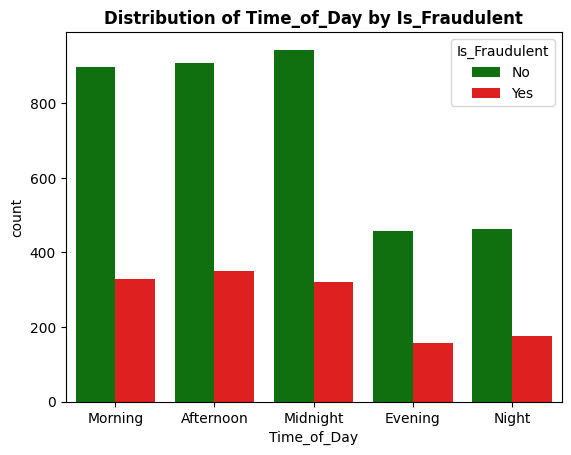

In [29]:
sns.countplot(data=df, x='Time_of_Day', hue='Is_Fraudulent', palette=['green', 'red'])
plt.title('Distribution of Time_of_Day by Is_Fraudulent', fontweight='bold')
plt.show()

- A slight tall bar (`Morning, Afternoon, Midnight`) for `Is_Fraudulent == Yes` shows most of the fraud transactions are held during these hours.

- But the statistical test shows there is no dependency.

#### Fraudulent Transactions by Hour

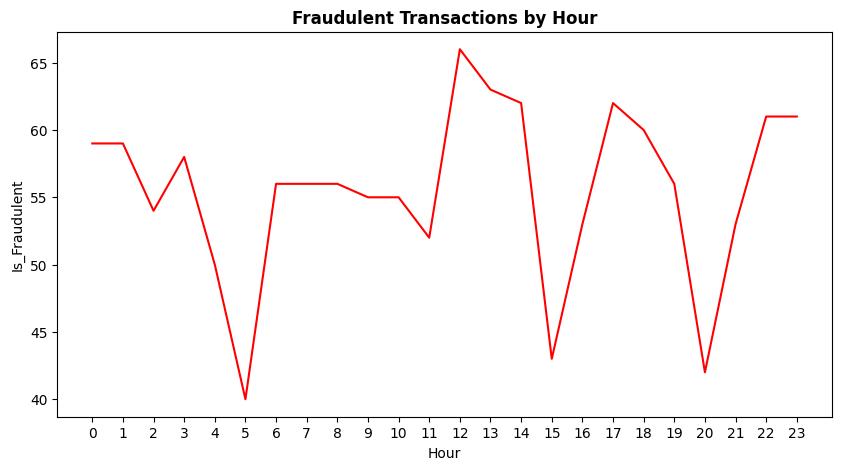

In [30]:
f_count = df.groupby('Hour')['Is_Fraudulent'].apply(lambda x: (x == 'Yes').sum()).reset_index(name='Is_Fraudulent')

plt.figure(figsize=(10, 5))
sns.lineplot(data=f_count, x='Hour', y='Is_Fraudulent', color='red')
plt.title('Fraudulent Transactions by Hour', fontweight='bold')
plt.xticks(f_count['Hour'])
plt.show()

- Fraud Transactions counts are drastically increasing from morning 5 AM to Noon 12 PM then it's fluctuating.

#### Average Fraudulant Transaction by Month

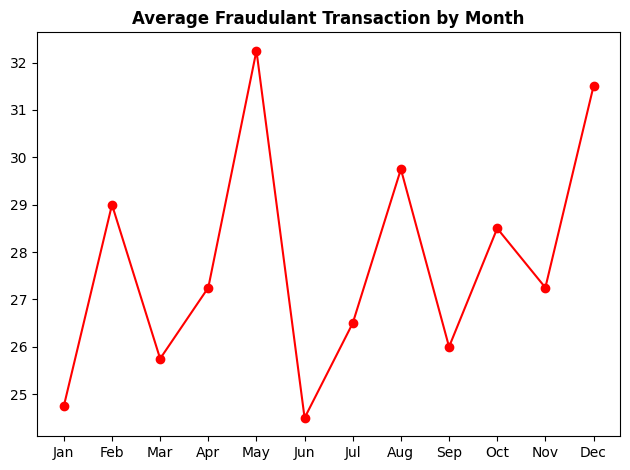

In [31]:
import calendar

plt.plot(pd.DataFrame(
            df.groupby(['Year', 'Month'])['Is_Fraudulent']
            .apply(lambda x: (x == 'Yes').sum())
            .reset_index(name='Fraudulent_Count')
        ).groupby('Month')['Fraudulent_Count'].mean(), color='red', marker='o')
plt.title('Average Fraudulant Transaction by Month', fontweight='bold')
plt.xticks(ticks=range(1, 13), labels=calendar.month_abbr[1:])
plt.tight_layout()

- **May Spike**: The increase in fraudulent transactions during May could be tied to specific events, such as:

    - High online shopping activity (e.g., end-of-season sales).
    
    - Tax filing deadlines or financial activity peaks (fraudsters often exploit busy financial periods).

- **June Decline**: The drastic reduction in June might indicate:

    - Reduced financial transactions or less online activity post-May.
    
    - Enforcement actions or system updates that deter fraud after a peak.

#### Cumulative Fraudulant Transaction by Year

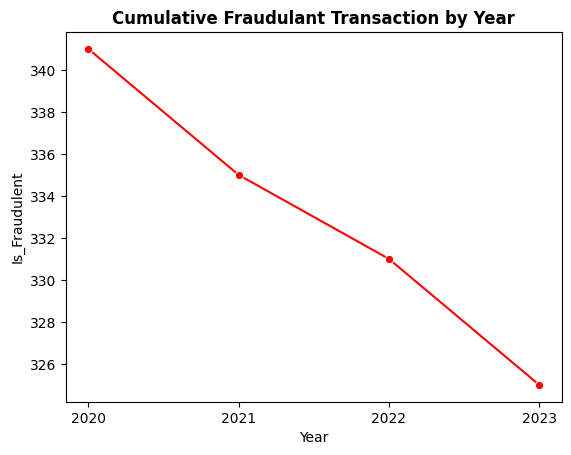

In [32]:
result = df.groupby('Year')['Is_Fraudulent'].apply(lambda x: (x == 'Yes').sum()).reset_index(name='Is_Fraudulent')

sns.lineplot(x=result['Year'], y=result['Is_Fraudulent'], color='red', marker='o')
plt.title('Cumulative Fraudulant Transaction by Year', fontweight='bold')
plt.xticks(result['Year'])
plt.show()

- Fraudulent Transactions are decreasing year-on-year which is a positive sign.

### Multivariate Analysis

#### Correlation Heatmap between Numerical Features

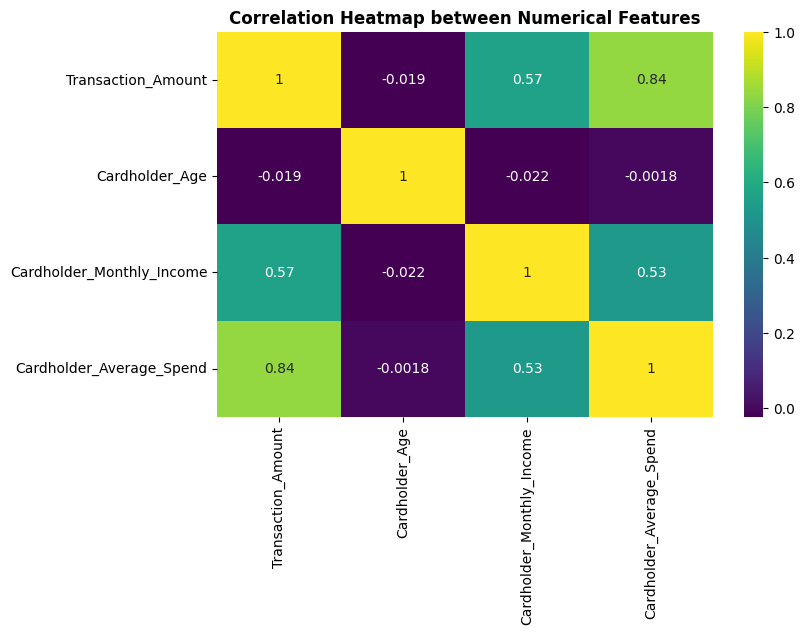

In [33]:
plt.figure(figsize=(8, 5))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='viridis')
plt.title('Correlation Heatmap between Numerical Features', fontweight='bold')
plt.show()

- There is a strong positive correlation between the features like,
  
    - `Transaction_Amount` and `Cardholder_Average_Spend`

    - `Cardholder_Monthly_Income` and `Credit_Limit`

- There is mild positive correlation between the features like,
  
    - `Transaction_Amount` and `Credit_Limit`

    - `Transaction_Amount` and `Cardholder_Monthly_Income`

    - `Cardholder_Monthly_Income` and `Cardholder_Average_Spend`

    - `Cardholder_Average_Spend` and `Credit_Limit`

- These correlations are quite common.

#### Correlation between Target and Numerical Features

In [34]:
from scipy.stats import pointbiserialr

df['Is_Fraudulent'] = df['Is_Fraudulent'].replace({'No' : 0, 'Yes' : 1})

for col in numerical_cols:
    correlation, p_value = pointbiserialr(df.dropna()['Is_Fraudulent'], df.dropna()[col])
    print(f'{col}\nPoint Biserial Correlation : {correlation} \nP-value : {p_value}\n')

Transaction_Amount
Point Biserial Correlation : -0.018326840796708772 
P-value : 0.23393367663804243

Cardholder_Age
Point Biserial Correlation : -0.012077226667323755 
P-value : 0.4328340253671689

Cardholder_Monthly_Income
Point Biserial Correlation : -0.02017946737557287 
P-value : 0.18998140887458098

Cardholder_Average_Spend
Point Biserial Correlation : -0.017547403088801136 
P-value : 0.2544295854665933



In [35]:
df.head()

,Transaction_ID,Card_Type,Merchant_Category,Transaction_Amount,Transaction_DateTime,City,Country,Cardholder_Age,Cardholder_Gender,Cardholder_Monthly_Income,Cardholder_Average_Spend,Credit_Limit,Device_Type,Day_of_Week,Is_Fraudulent,Year,Month,Hour,Time_of_Day
0,W963UK57,Mastercard,Utility bill,2721.4,2020-01-01 09:43:00,Tokyo,Japan,23.0,Female,9463.0,3636.965,10000.0,Unknown,Wednesday,0,2020,1,9,Morning
1,V606KV56,UnionPay,Retail,8395.6,2020-01-03 16:26:00,Tokyo,Japan,49.0,Male,14812.0,8917.912,15000.0,Desktop,Friday,0,2020,1,16,Afternoon
2,R531NU70,Visa,Transportation,19328.0,2020-01-04 03:40:00,London,UK,NaN,Male,21092.0,10666.860,20000.0,Desktop,Saturday,0,2020,1,3,Midnight
3,T783GF79,American Express,Online Shopping,16738.1,2020-01-04 14:56:00,Tokyo,Japan,52.0,Female,14807.0,17315.552,20000.0,Desktop,Saturday,1,2020,1,14,Afternoon
4,K256ZN73,American Express,Retail,8117.0,2020-01-04 17:26:00,Chicago,USA,37.0,Female,17447.0,5271.309,20000.0,Mobile,Saturday,0,2020,1,17,Afternoon


In [36]:
print(numerical_cols)

['Transaction_Amount', 'Cardholder_Age', 'Cardholder_Monthly_Income', 'Cardholder_Average_Spend']


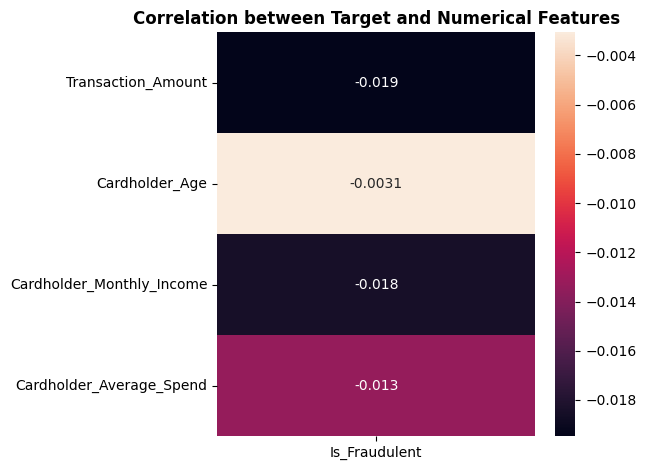

In [37]:
corr_matrix = df[numerical_cols + ['Is_Fraudulent']].corr()['Is_Fraudulent'].drop('Is_Fraudulent').to_frame()
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation between Target and Numerical Features', fontweight='bold')
plt.tight_layout()

- From the statistical test and heatmap we can see there is very low correlation between numerical features and target which the correlation is nearly equal to 0.

- We can conclude that individual we don't see any features which showing high correlation with the target.

### 2. Data Preprocessing- Data Cleaning:

#### Handling Missing Values

In [38]:
null_count = df.isnull().sum()
null_count[null_count > 0]

,0
Card_Type,17
Merchant_Category,22
Transaction_Amount,6
Cardholder_Age,135
Cardholder_Gender,89
Cardholder_Monthly_Income,314
Cardholder_Average_Spend,208
Credit_Limit,9
Device_Type,40


In [39]:
print(numerical_cols)

['Transaction_Amount', 'Cardholder_Age', 'Cardholder_Monthly_Income', 'Cardholder_Average_Spend']


Using `KNNImputer` from to handle missing values in the numerical columns of the dataset.  
The imputation process fills in missing data based on the values of the nearest neighbors (rows) that are similar to the missing data points.

In [40]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed_data = imputer.fit_transform(df[numerical_cols])
df[numerical_cols] = pd.DataFrame(imputed_data, columns=numerical_cols)

df[numerical_cols].isnull().sum()

,0
Transaction_Amount,0
Cardholder_Age,0
Cardholder_Monthly_Income,0
Cardholder_Average_Spend,0


In [41]:
print(categorical_cols)

['Card_Type', 'Merchant_Category', 'City', 'Country', 'Cardholder_Gender', 'Device_Type', 'Day_of_Week', 'Is_Fraudulent', 'Credit_Limit']


Handling missing values in the categorical columns of the dataset by imputing them with the mode (most frequent value) of each respective column. This approach is commonly used for categorical data as it fills missing values with the most common category.

In [42]:
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

df[categorical_cols].isnull().sum()

,0
Card_Type,0
Merchant_Category,0
City,0
Country,0
Cardholder_Gender,0
Device_Type,0
Day_of_Week,0
Is_Fraudulent,0
Credit_Limit,0


### Handling Outliers

In [43]:
for col in ('Transaction_Amount', 'Cardholder_Average_Spend'):
    upper_bound = df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))

    print(f'Fraud Distribution for Outliers in {col}:')
    # Filter and get the value counts for Is_Fraudulent in outliers
    outliers = df[df[col] > upper_bound]
    print(outliers['Is_Fraudulent'].value_counts(normalize=True).to_string(), "\n")

    print(f'Fraud Distribution for Non-Outliers in {col}:')
    # Filter and get the value counts for Is_Fraudulent in non-outliers
    non_outliers = df[df[col] <= upper_bound]
    print(non_outliers['Is_Fraudulent'].value_counts(normalize=True).round(2).to_string(), "\n")


Fraud Distribution for Outliers in Transaction_Amount:
Is_Fraudulent
0    0.752577
1    0.247423 

Fraud Distribution for Non-Outliers in Transaction_Amount:
Is_Fraudulent
0    0.73
1    0.27 

Fraud Distribution for Outliers in Cardholder_Average_Spend:
Is_Fraudulent
0    0.758389
1    0.241611 

Fraud Distribution for Non-Outliers in Cardholder_Average_Spend:
Is_Fraudulent
0    0.73
1    0.27 



- A quarter (25%) of outliers in both `Transaction_Amount` and `Cardholder_Average_Spend` are linked to fraudulent transactions.
  
- This is significantly higher than what might be expected in a balanced dataset where fraud rates are typically low. Hence, outliers could be indicative of fraudulent activity but not overwhelmingly so.

- 75% of outliers are non-fraudulent in both cases. This suggests that not all outliers are inherently suspicious or fraudulent.

- These outliers may represent legitimate transactions and should be retained.

### 3. Feature Engineering:

In [44]:
df.head(3)

,Transaction_ID,Card_Type,Merchant_Category,Transaction_Amount,Transaction_DateTime,City,Country,Cardholder_Age,Cardholder_Gender,Cardholder_Monthly_Income,Cardholder_Average_Spend,Credit_Limit,Device_Type,Day_of_Week,Is_Fraudulent,Year,Month,Hour,Time_of_Day
0,W963UK57,Mastercard,Utility bill,2721.4,2020-01-01 09:43:00,Tokyo,Japan,23.000000,Female,9463.0,3636.965,10000.0,Unknown,Wednesday,0,2020,1,9,Morning
1,V606KV56,UnionPay,Retail,8395.6,2020-01-03 16:26:00,Tokyo,Japan,49.000000,Male,14812.0,8917.912,15000.0,Desktop,Friday,0,2020,1,16,Afternoon
2,R531NU70,Visa,Transportation,19328.0,2020-01-04 03:40:00,London,UK,39.333333,Male,21092.0,10666.860,20000.0,Desktop,Saturday,0,2020,1,3,Midnight


In [45]:
df['Year'].unique()

array([2020, 2021, 2022, 2023], dtype=int32)

In [46]:
df = df.drop(columns='Transaction_DateTime')

cols_to_encode = df.drop(columns='Transaction_ID').select_dtypes(include='O').columns.to_list()
cols_to_encode.extend(['Credit_Limit', 'Year'])
print(cols_to_encode)

['Card_Type', 'Merchant_Category', 'City', 'Country', 'Cardholder_Gender', 'Device_Type', 'Day_of_Week', 'Time_of_Day', 'Credit_Limit', 'Year']


In [47]:
from sklearn.preprocessing import LabelEncoder

for col in cols_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [48]:
df[categorical_cols].head()

,Card_Type,Merchant_Category,City,Country,Cardholder_Gender,Device_Type,Day_of_Week,Is_Fraudulent,Credit_Limit
0,1,7,11,6,0,4,6,0,1
1,2,5,11,6,1,1,0,0,2
2,3,6,4,8,1,1,2,0,3
3,0,4,11,6,0,1,2,1,3
4,0,5,1,9,0,2,2,0,3


### 4.  Feature Selection:

In [49]:
X = df.drop(columns=['Is_Fraudulent', 'Transaction_ID'])
y = df['Is_Fraudulent']

In [50]:
X.columns

Index(['Card_Type', 'Merchant_Category', 'Transaction_Amount', 'City',
       'Country', 'Cardholder_Age', 'Cardholder_Gender',
       'Cardholder_Monthly_Income', 'Cardholder_Average_Spend', 'Credit_Limit',
       'Device_Type', 'Day_of_Week', 'Year', 'Month', 'Hour', 'Time_of_Day'],
      dtype='object')

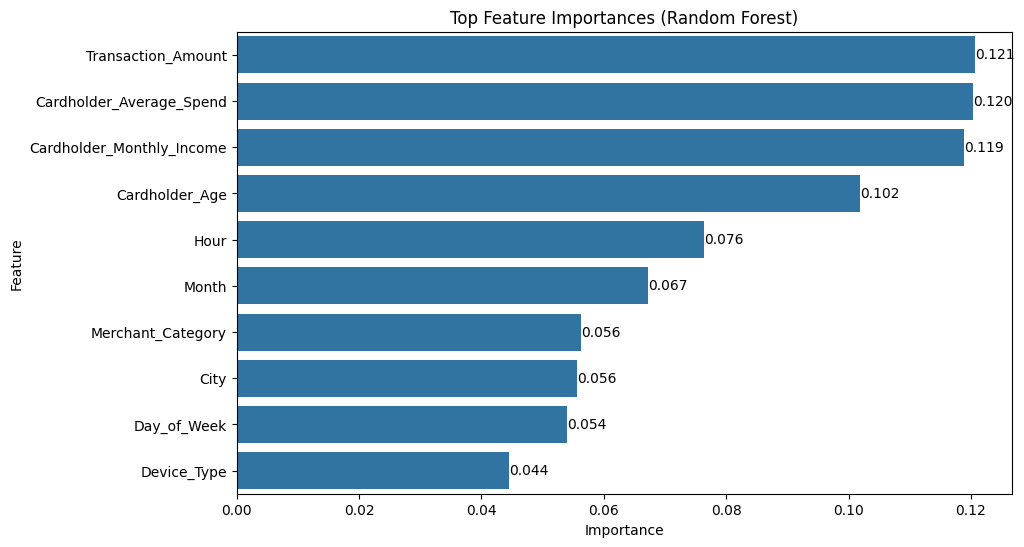

In [51]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X, y)

feature_importances = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))   # Select top 10 features
ax.bar_label(ax.containers[0], labels=[f'{p.get_width():.3f}' for p in ax.patches])
plt.title('Top Feature Importances (Random Forest)')
plt.show()

In [52]:
threshold = 0.05    # threshold for feature importance
selected_features = X.columns[feature_importances > threshold]  # Get the features that have importance greater than the threshold
X_selected = X[selected_features]

In [53]:
X_selected.columns

Index(['Merchant_Category', 'Transaction_Amount', 'City', 'Cardholder_Age',
       'Cardholder_Monthly_Income', 'Cardholder_Average_Spend', 'Day_of_Week',
       'Month', 'Hour'],
      dtype='object')

### 5. Split data into training and testing

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=100, stratify=y)

In [55]:
print(f'Value Counts for y_train: \n{y_train.value_counts(normalize=True).round(2).to_string()}\n')
print(f'Value Counts for y_test: \n{y_test.value_counts(normalize=True).round(2).to_string()}')

Value Counts for y_train: 
Is_Fraudulent
0    0.73
1    0.27

Value Counts for y_test: 
Is_Fraudulent
0    0.73
1    0.27


In [56]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [57]:
y_train.value_counts(normalize=True).round(2)

,proportion
Is_Fraudulent,
0,0.5
1,0.5


- As we can see both sets maintain the same distribution of fraudulent and non-fraudulent transactions to avoid data leakage.

### 6. Feature Scaling

In [58]:
df[numerical_cols].head(3)

,Transaction_Amount,Cardholder_Age,Cardholder_Monthly_Income,Cardholder_Average_Spend
0,2721.4,23.000000,9463.0,3636.965
1,8395.6,49.000000,14812.0,8917.912
2,19328.0,39.333333,21092.0,10666.860


In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols]).round(3)
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols]).round(3)

### 7. Build the Machine Learning Model

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

In [61]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(max_depth=4),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Classifier': SVC()
}

results = {}

for name, clf in classifiers.items():
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  results[name] = {'Accuracy': accuracy, 'F1 Score': f1}

results_df = pd.DataFrame(results).T
results_df

,Accuracy,F1 Score
Logistic Regression,0.525,0.335664
Gaussian Naive Bayes,0.536,0.331412
Decision Tree,0.472,0.383178
Random Forest,0.593,0.242086
K-Nearest Neighbors,0.485,0.333765
Support Vector Classifier,0.516,0.292398


Given the trade-off between accuracy and F1 score, **Random Forest** appears to be the best model overall because of its strong performance in both metrics.

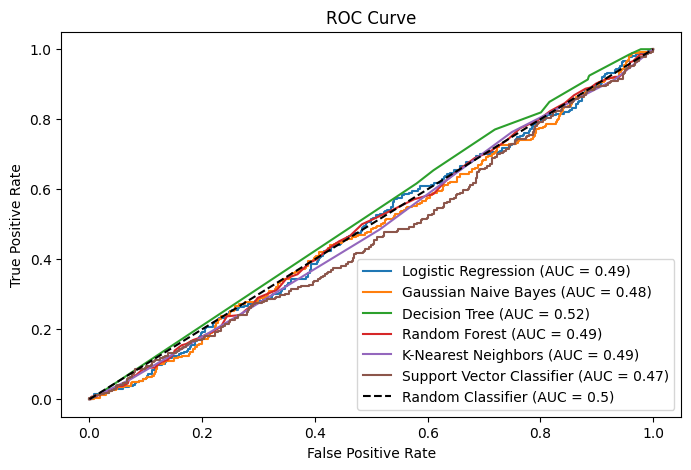

In [62]:
plt.figure(figsize=(8, 5))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_probs = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Classifier (AUC = 0.5)') # Plot diagonal line (random model)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

While all models have AUC scores close to 0.5, as AUC-ROC can be less informative for imbalanced datasets.

In [63]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

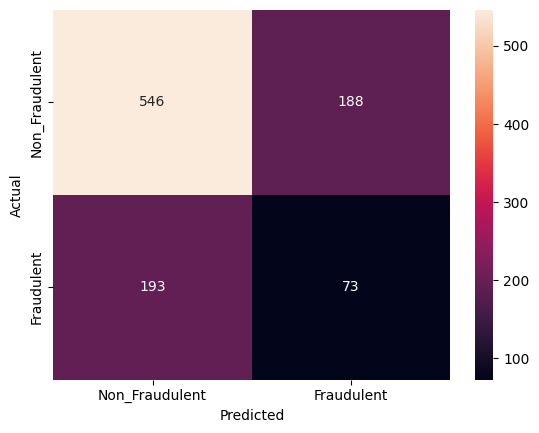

In [64]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Non_Fraudulent', 'Fraudulent']
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [65]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74       734
           1       0.28      0.27      0.28       266

    accuracy                           0.62      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.62      0.62      0.62      1000



#### Cross-validation and Hyper-parameter Tuning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes  import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC

clfs = {
    'LogisticRegression' : LogisticRegression(),
    'KNeighborsClassifier' : KNeighborsClassifier(),
    'DecisionTreeClassifier' : DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier' : RandomForestClassifier(random_state=42),
    'AdaBoostClassifier' : AdaBoostClassifier(algorithm='SAMME', random_state=42),
    'GradientBoostingClassifier' : GradientBoostingClassifier(random_state=42),
    'GaussianNB' : GaussianNB(),
    'XGBClassifier' : XGBClassifier(random_state=42),
    'SVC' : SVC(random_state=42)
}

para_grid = {
    'LogisticRegression': {'max_iter': list(range(100, 500, 100))},
    'KNeighborsClassifier': {'n_neighbors': list(range(5, 16))},
    'DecisionTreeClassifier' : {'max_depth' : list(range(1, 11))},
    'RandomForestClassifier' : {'n_estimators' : list(range(50, 201, 50)), 'max_depth' : list(range(5, 21, 5))},
    'AdaBoostClassifier' : {'n_estimators' : list(range (50, 201, 50))},
    'GradientBoostingClassifier' : {'n_estimators' : list(range(50, 301, 50))},
    'GaussianNB' : {'var_smoothing': [1e-12, 1e-10, 1e-9, 1e-8, 1e-6, 1e-4]},
    'XGBClassifier' : {'n_estimators' : list(range(100, 1001, 100)), 'max_depth' : list(range(5, 21, 5))},
    'SVC' : {'C': [1, 10], 'kernel' : ['rbf', 'linear']}
}

In [ ]:
from sklearn.model_selection import GridSearchCV

best_models = {}
cv_scores = {}

for name, clf in clfs.items():
    print(f"\033[1m{name}\033[0m")

    grid_search = GridSearchCV(estimator=clf, param_grid=para_grid[name], scoring='accuracy', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    cv_scores[name] = {'Cross-Validated Score' : grid_search.best_score_}

    print(f"Best Parameters : {grid_search.best_params_}")
    print(f"Best Cross-Validated Score : {grid_search.best_score_}\n")

result_df = pd.DataFrame(cv_scores).T
print(f'\033[1mCross-Validated Score for each classifier (after GridSearchCV)\033[0m')
result_df

LogisticRegression
Best Parameters : {'max_iter': 100}
Best Cross-Validated Score : 0.6066972526363333

KNeighborsClassifier
Best Parameters : {'n_neighbors': 5}
Best Cross-Validated Score : 0.6395850125843981

DecisionTreeClassifier
Best Parameters : {'max_depth': 8}
Best Cross-Validated Score : 0.6317526225363117

RandomForestClassifier
Best Parameters : {'max_depth': 20, 'n_estimators': 200}
Best Cross-Validated Score : 0.7195260772259425

AdaBoostClassifier
Best Parameters : {'n_estimators': 200}
Best Cross-Validated Score : 0.6457287840697349

GradientBoostingClassifier
Best Parameters : {'n_estimators': 300}
Best Cross-Validated Score : 0.6994171818790474

GaussianNB
Best Parameters : {'var_smoothing': 0.0001}
Best Cross-Validated Score : 0.6332883112507279

XGBClassifier
Best Parameters : {'max_depth': 10, 'n_estimators': 200}
Best Cross-Validated Score : 0.7352024759240783

SVC
Best Parameters : {'C': 10, 'kernel': 'rbf'}
Best Cross-Validated Score : 0.6539130725247657

Cross-V

,Cross-Validated Score
LogisticRegression,0.606697
KNeighborsClassifier,0.639585
DecisionTreeClassifier,0.631753
RandomForestClassifier,0.719526
AdaBoostClassifier,0.645729
GradientBoostingClassifier,0.699417
GaussianNB,0.633288
XGBClassifier,0.735202
SVC,0.653913


In [69]:
selected_model = best_models[result_df.idxmax().iloc[0]]
y_pred = selected_model.predict(X_test)

print("\nClassification Report (Test Set):\n", classification_report(y_test, y_pred))


Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.74      0.75      0.75       734
           1       0.29      0.28      0.28       266

    accuracy                           0.63      1000
   macro avg       0.52      0.52      0.52      1000
weighted avg       0.62      0.63      0.62      1000

